In [1]:
import os
import glob
import pandas as pd
import plotly as py
import cufflinks as cf
%matplotlib inline

In [2]:
path_to_csv = "/home/SharedFolder/trained_models/night-drive/weather_classifier/with_cloudy/train_A_over_ganaug_050"
plot_title = "train_A_over_ganaug_050"

In [3]:
csv_files = glob.glob(path_to_csv + "/*.csv")

### Combine CSVs into one DataFrame ###

In [4]:
df = pd.DataFrame()
for csv_file in csv_files:
    df = pd.concat([df, pd.read_csv(csv_file)], axis = 0)
df = df.reset_index(drop = True)

### Some preprocessing ###

In [5]:
df = df.drop(columns = ["weights"])
df.head()

,epoch,data,f1_score_weighted,f1_score_micro,f1_score_macro,accuracy,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,1,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.684198,0.683,0.653381,0.683,0.891906,0.876886,0.751717,0.744191,0.521790
1,2,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.734817,0.733,0.710221,0.733,0.919839,0.912109,0.809790,0.807812,0.602097
2,3,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.766528,0.765,0.741804,0.765,0.931910,0.927137,0.836739,0.834317,0.647826
3,4,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.779060,0.778,0.758385,0.778,0.939885,0.934350,0.854656,0.846476,0.663367
4,5,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.789192,0.788,0.768440,0.788,0.940590,0.937439,0.856864,0.852219,0.679486


In [6]:
df.data = df.data.apply(lambda x: x.split(os.sep)[-1].split(".json")[0].split("bdd100k_sorted_")[-1])
df = df.sort_values(by = ["data", "epoch"])
df = df.reset_index(drop = True)
df.head()

,epoch,data,f1_score_weighted,f1_score_micro,f1_score_macro,accuracy,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,1,test,0.555629,0.5365,0.505360,0.5365,0.791492,0.811733,0.597558,0.620043,0.343895
1,2,test,0.595721,0.5805,0.555052,0.5805,0.841961,0.857228,0.672915,0.705196,0.406397
2,3,test,0.650545,0.6365,0.604178,0.6365,0.873940,0.881492,0.727692,0.748481,0.473126
3,4,test,0.674526,0.6610,0.628997,0.6610,0.886242,0.895420,0.752382,0.772274,0.509701
4,5,test,0.693643,0.6820,0.642970,0.6820,0.899185,0.900255,0.776542,0.782280,0.527710


### Load training log file ###

In [7]:
train_log_file = glob.glob(path_to_csv + "/*.txt")
assert(len(train_log_file) == 1)

In [8]:
df_loss = pd.read_csv(train_log_file[0], sep = " ", header = None, skiprows = [0, 1])
df_loss.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,Epoch,"1/40,",Batch,10/399:,Train,Loss,=,1.521,Valid,Loss,=,1.575,ETA,=,6.79h
1,Epoch,"1/40,",Batch,20/399:,Train,Loss,=,1.517,Valid,Loss,=,1.529,ETA,=,6.35h
2,Epoch,"1/40,",Batch,30/399:,Train,Loss,=,1.481,Valid,Loss,=,1.464,ETA,=,5.22h
3,Epoch,"1/40,",Batch,40/399:,Train,Loss,=,1.460,Valid,Loss,=,1.452,ETA,=,5.36h
4,Epoch,"1/40,",Batch,50/399:,Train,Loss,=,1.422,Valid,Loss,=,1.389,ETA,=,5.17h


In [9]:
df_loss = df_loss.iloc[:, [1, 3, 7, 11]].rename(columns = {1: "epoch", 3: "batch", 7: "train_loss", 11: "train_dev_loss"})
df_loss.epoch = df_loss.epoch.apply(lambda x: int(x.split("/")[0]))
df_loss.batch = df_loss.batch.apply(lambda x: int(x.split("/")[0]))
df_loss["global_batch"] = (df_loss.epoch - 1) * df_loss.batch.max() + df_loss.batch
df_loss = df_loss.sort_values(by = ["epoch", "batch"]).set_index("global_batch", drop = True)
df_loss.head()

,epoch,batch,train_loss,train_dev_loss
global_batch,,,,
10,1,10,1.521,1.575
20,1,20,1.517,1.529
30,1,30,1.481,1.464
40,1,40,1.460,1.452
50,1,50,1.422,1.389


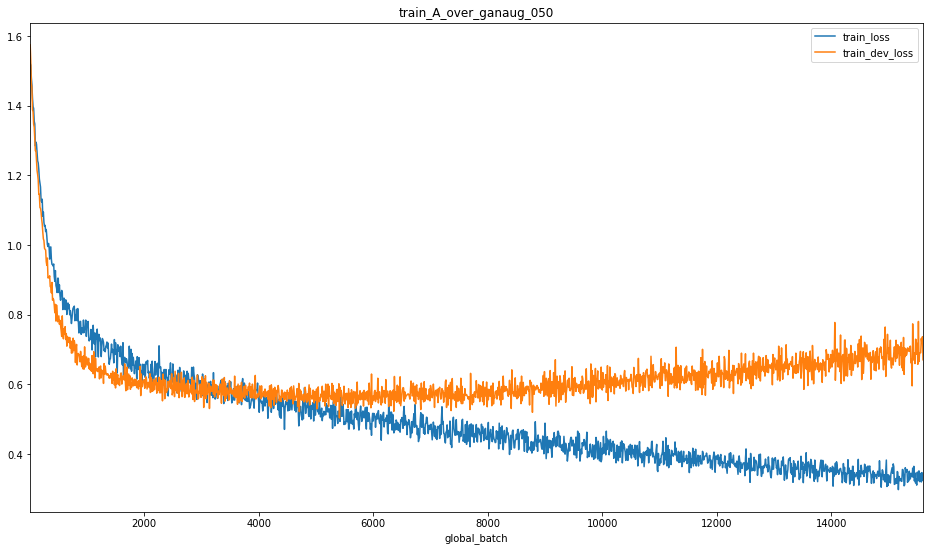

In [10]:
df_loss.plot(y = ["train_loss", "train_dev_loss"], title = plot_title, figsize = (16, 9))

### Combine loss, scores  and plot ###

In [11]:
df_combined = df_loss.groupby(by = ["epoch"]).median()
df_combined = df_combined.drop(columns = ["batch"])
df_combined.head()

,train_loss,train_dev_loss
epoch,,
1,1.132,1.095
2,0.842,0.746
3,0.755,0.663
4,0.703,0.629
5,0.662,0.611


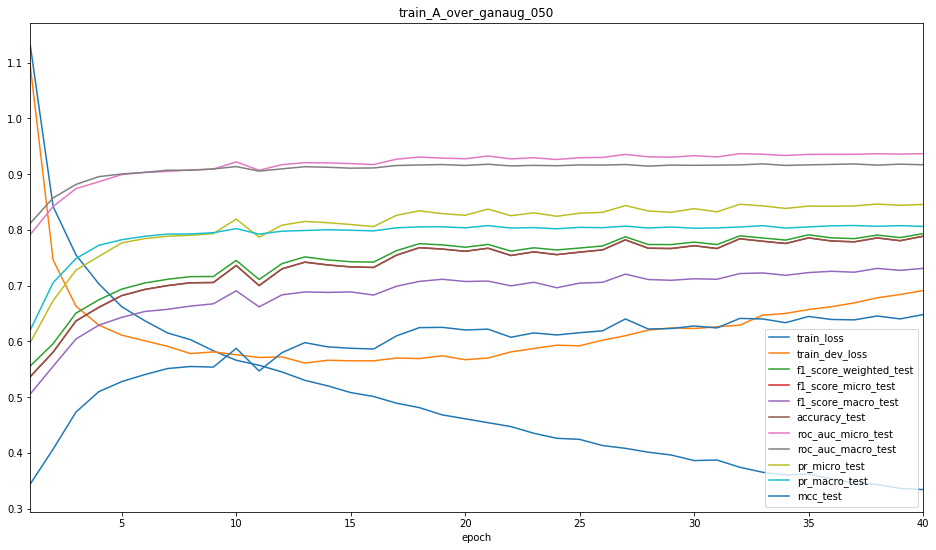

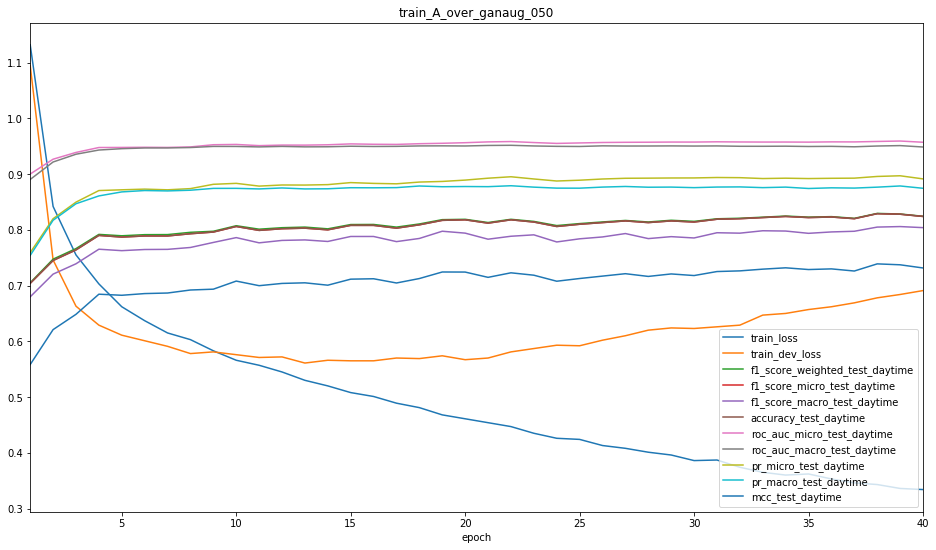

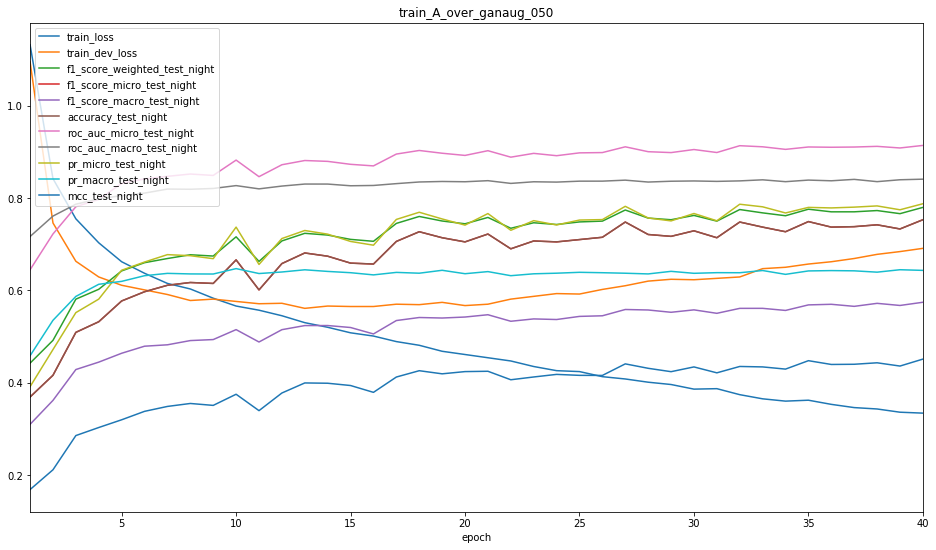

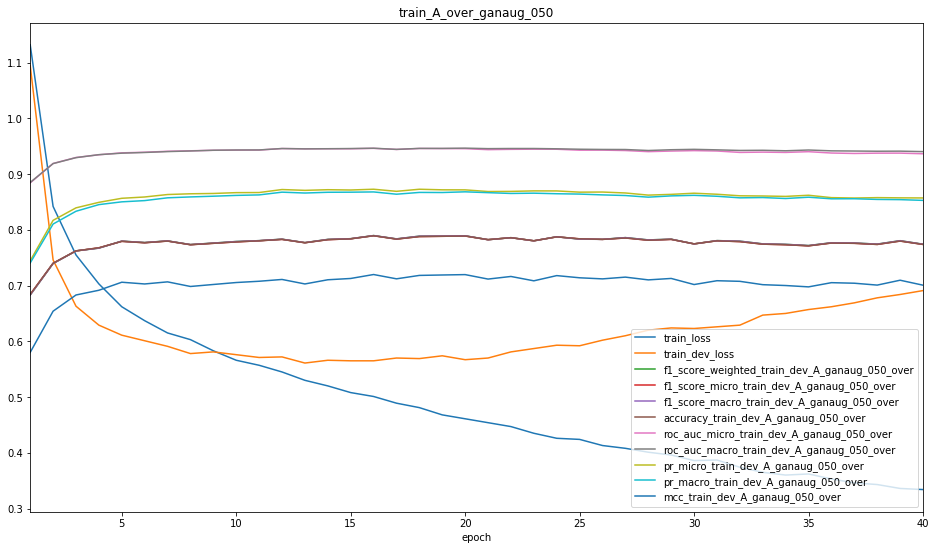

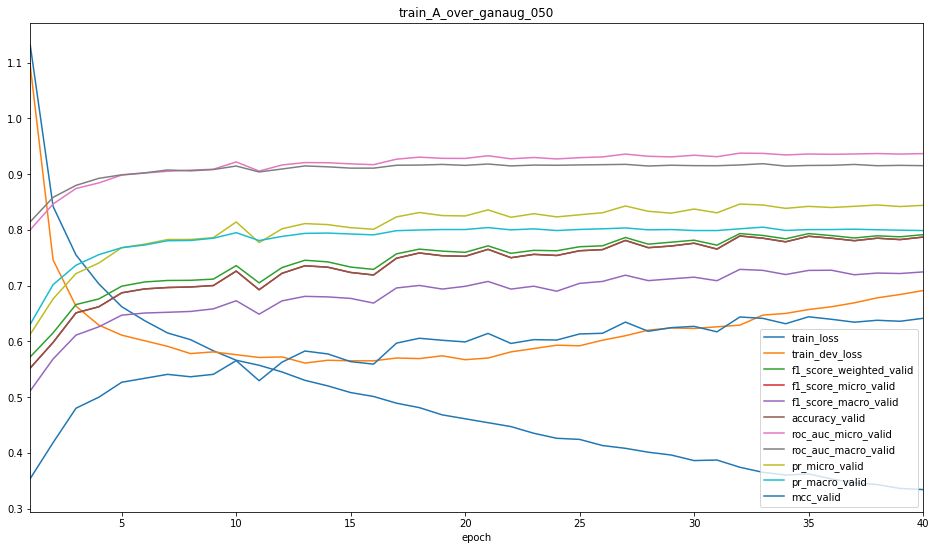

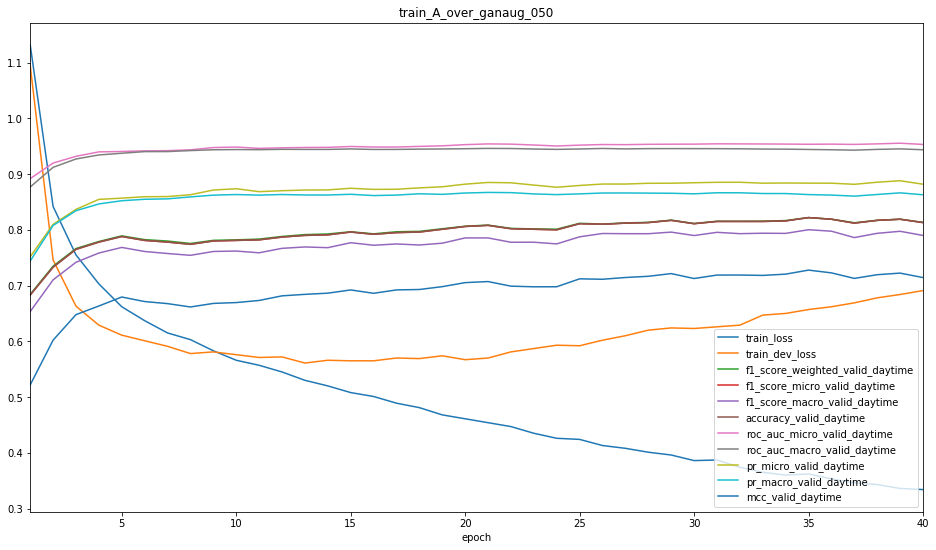

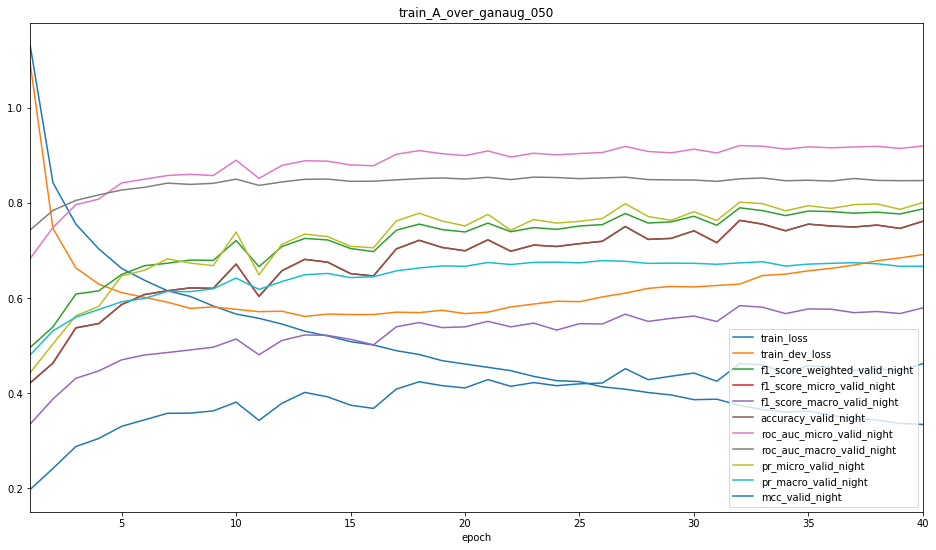

In [12]:
for data in df.data.unique():
    df_data = df.loc[df.data == data]
    df_data = df_data.drop(columns = ["data"])
    df_data = df_data.set_index("epoch", drop = True)
    df_data = df_data.add_suffix("_" + data)
    df_combined_data = df_combined.merge(df_data, on = "epoch")
    df_combined_data.plot(title = plot_title, figsize = (16, 9))

### Interactive Plotly Plots ##

In [13]:
cf.go_offline(connected = True)
config = {
    "modeBarButtonsToRemove": ["sendDataToCloud"],
    "displaylogo": False
}
layout = {
    "title": plot_title,
    "xaxis": {
        "title": "epoch"
    },    
    "width": 960,
    "height": 540
}
for data in df.data.unique():
    df_data = df.loc[df.data == data]
    df_data = df_data.drop(columns = ["data"])
    df_data = df_data.set_index("epoch", drop = True)
    df_data = df_data.add_suffix("_" + data)
    df_combined_data = df_combined.merge(df_data, on = "epoch")
    fig = df_combined_data.iplot(layout = layout, asFigure = True)
    py.offline.iplot(fig, show_link = False, config = config)